## Lab 2
#### Jason Chou

* Goal: Classifying and hand-wavy estimate of spectral type and temperature of the observed stars from their optical spectra

In [40]:
%%capture
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import fitmodel
import astropy.units as u
import astropy.constants as cc

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

%matplotlib inline

---
## Data - reduced spectra
### Target and calibration stars
* **Targets:** 
<p style="text-indent: 20px">Capella - g2<br>
<p style="text-indent: 20px">$\alpha$ Cam - u1<br>
* **Calibrs:** 
<p style="text-indent: 20px">$\gamma$ UMa - a.k.a. HR 4554<br>
<p style="text-indent: 20px">$\eta$ Hya - a.k.a. HR3454

### What we know
From Wikipedia, we could dig out some information of the stars -- what we should see in our analysis.<br>
* **Targets:** 
<p style="text-indent: 20px">[Capella](https://en.wikipedia.org/wiki/Capella): Actually two pairs of binaries. The brighter pair consists of two stars classified as K0 and G1. Surface temperature $\sim$5000 K<br>
<p style="text-indent: 20px">[$\alpha$ Cam](https://en.wikipedia.org/wiki/Alpha_Camelopardalis): O9 supergiant. Its surface temperature is estimated to be around 30000 K<br>
* **Calibrs:** 
<p style="text-indent: 20px">[$\gamma$ UMa](https://en.wikipedia.org/wiki/Gamma_Ursae_Majoris): An Ae star classified as A0 type with effective surface temperature of $\sim$9400 K<br>
<p style="text-indent: 20px">[$\eta$ Hya](https://en.wikipedia.org/wiki/Eta_Hydrae): B3 star with surface temperature of $\sim$18500 K

---
### Reduced spectra
_Note: We re-processed all the spectra, see the notebook `/afs/ir.stanford.edu/class/physics100/workdir/g2/Spectra/reduction/notesforcommands-new.ipynb`. The old spectra (those submitted last Friday) are considered erroreous. The corrected ones are shown below for your reference._

In [2]:
capella_dir   = '/afs/ir.stanford.edu/class/physics100/workdir/g2/Spectra/reduction/new/capella'
gamma_uma_dir = '/afs/ir.stanford.edu/class/physics100/workdir/g2/Spectra/reduction/new/gamma_uma'
alpha_cam_dir = '/afs/ir.stanford.edu/class/physics100/workdir/g2/Spectra/reduction/new/alpha_cam'
eta_hya_dir   = '/afs/ir.stanford.edu/class/physics100/workdir/g2/Spectra/reduction/new/eta_hya'

In [3]:
## read in the txt spectrum files
capella_spec = pd.read_csv(capella_dir+'/Capella_final_spec.txt',
                           header=None,delim_whitespace=True)
alpha_cam_spec = pd.read_csv(alpha_cam_dir+'/U1_alpha_cam_final_spec.txt',
                             header=None,delim_whitespace=True)
gamma_uma_spec = pd.read_csv(gamma_uma_dir+'/Gamma_UMa_final_spec.txt',
                             header=None,delim_whitespace=True)
eta_hya_spec = pd.read_csv(eta_hya_dir+'/U1_eta_hya_final_spec.txt',
                           header=None,delim_whitespace=True)

## wavelength and flux columns
capella_wvln = np.array(capella_spec[0])
capella_flux = np.array(capella_spec[1])

alpha_cam_wvln = np.array(alpha_cam_spec[0])
alpha_cam_flux = np.array(alpha_cam_spec[1])

gamma_uma_wvln = np.array(gamma_uma_spec[0])
gamma_uma_flux = np.array(gamma_uma_spec[1])

eta_hya_wvln = np.array(eta_hya_spec[0])
eta_hya_flux = np.array(eta_hya_spec[1])

First glance

(0, 2.6624789999999999e-10)

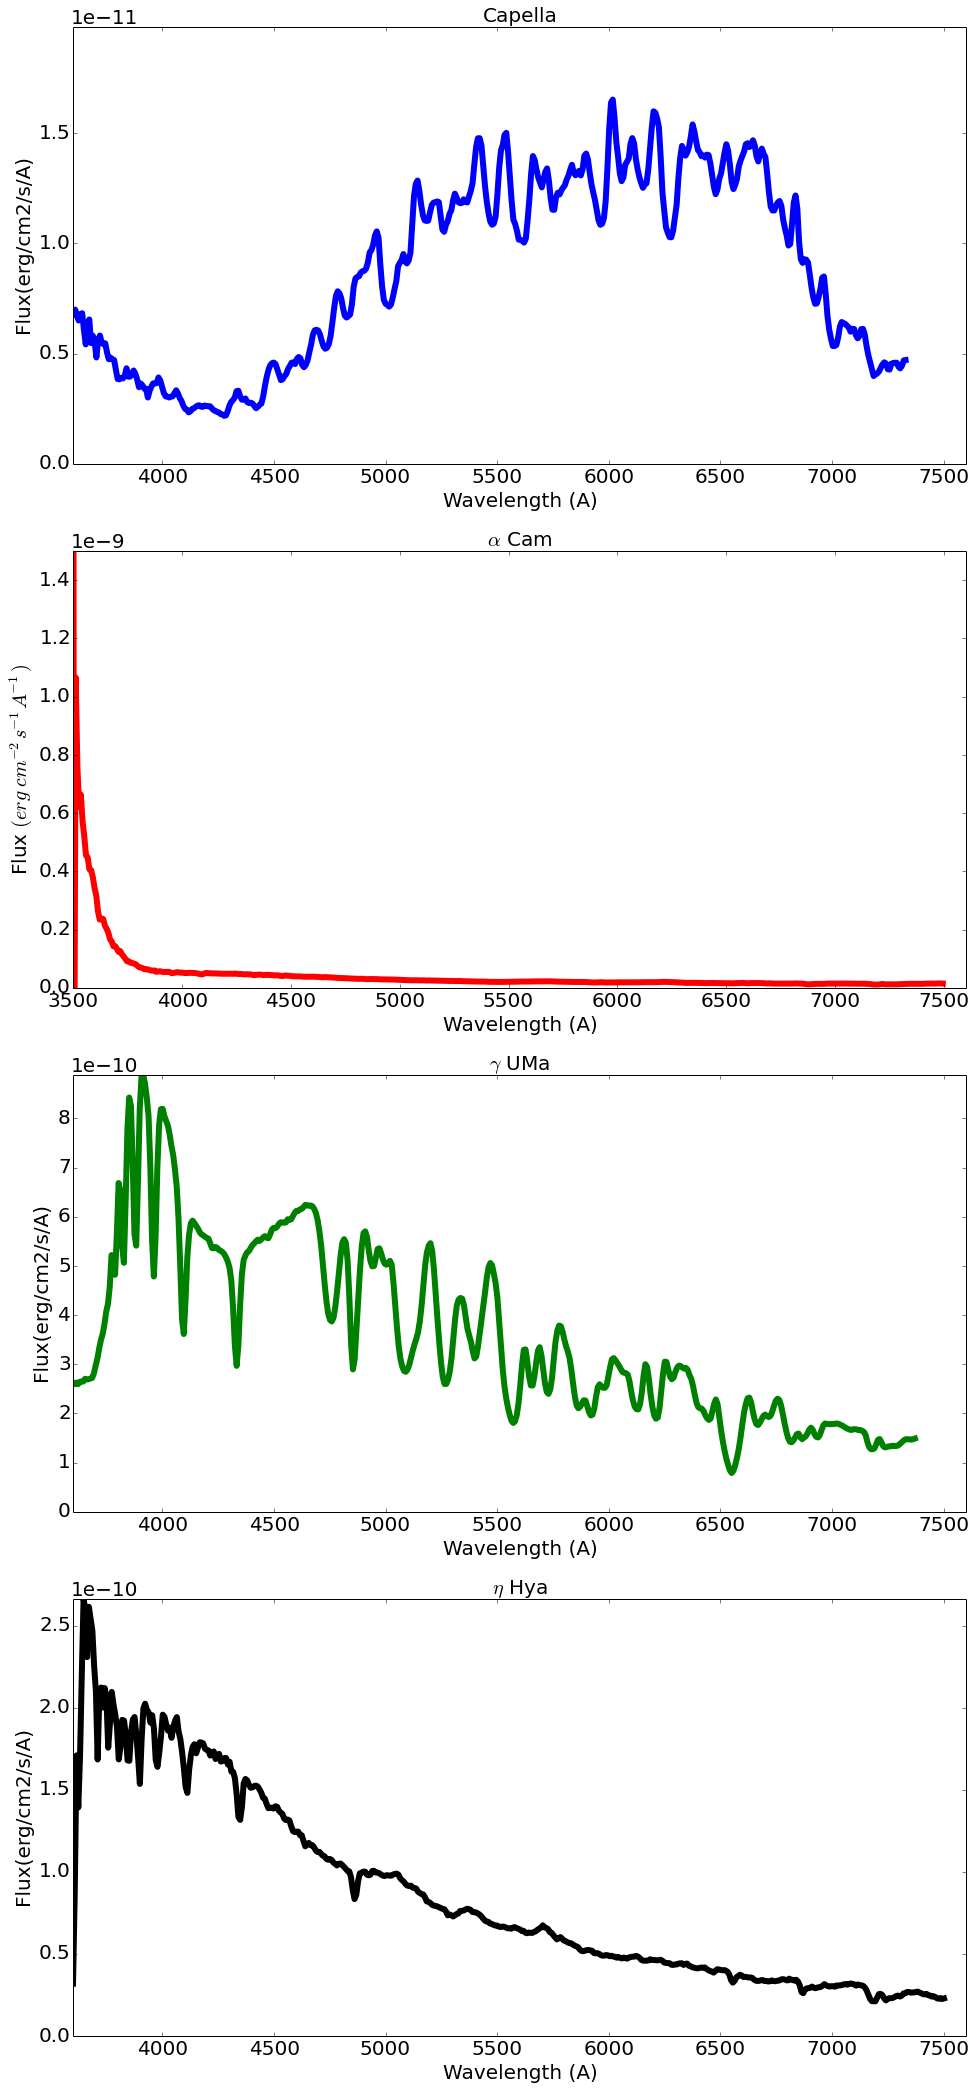

In [7]:
plt.figure(figsize=(16,36))
plt.subplot(411); plt.plot(capella_wvln,capella_flux,lw=6); 
plt.title('Capella'); plt.xlabel('Wavelength (A)'); plt.ylabel('Flux(erg/cm2/s/A)')
plt.xlim(3600,7600); plt.ylim(0,np.max(capella_flux[20:]))
plt.subplot(412); plt.plot(alpha_cam_wvln,alpha_cam_flux,'r',lw=6); 
plt.title(r'$\alpha$ Cam'); plt.xlabel('Wavelength (A)'); plt.ylabel('Flux $(erg\ cm^{-2} s^{-1} A^{-1})$')
plt.xlim(3500,7600); plt.ylim(0,1.5e-9)
plt.subplot(413); plt.plot(gamma_uma_wvln,gamma_uma_flux,'g',lw=6); 
plt.title(r'$\gamma$ UMa'); plt.xlabel('Wavelength (A)'); plt.ylabel('Flux(erg/cm2/s/A)')
plt.xlim(3600,7600); plt.ylim(0,np.max(gamma_uma_flux[20:]))
plt.subplot(414); plt.plot(eta_hya_wvln,eta_hya_flux,'k',lw=6); 
plt.title(r'$\eta$ Hya'); plt.xlabel('Wavelength (A)'); plt.ylabel('Flux(erg/cm2/s/A)')
plt.xlim(3600,7600); plt.ylim(0,np.max(eta_hya_flux[20:]))

#### Observations
Here we see that the spectra of the O and B stars ($\eta$ Hya and $\alpha$ Cam) peak somewhere near or outside the lower bound of our detectable wavelength range, as expected. On the other hand, $\gamma$ UMa does not look right intuitively since a spectrum peaking at 4000A would imply a surface temperature of only 7250K. However, it is an Ae star with envelope so it might not be warranted to classify it in the usual way. Indeer, more extended spectra (e.g. the ESO [database](https://www.eso.org/sci/observing/tools/standards/spectra/hr4554.html)) confirm that there is actually a second peak down at 1500A. Anyways, I'll ignore $\gamma$ UMa in the following analysis.

---
## Analyses
First we'll define the black-body spectrum function form

In [55]:
def blackbodymodel(lam, T, a):
    h = cc.h
    c = cc.c
    k = cc.k_B
    
    ## a is some normalization factor
    return (a*1e30) * (8*np.pi*h*c/lam**5)/(np.exp(h*c/(lam*k*T))-1)

def blackbodymodel_nounit(lam, T, a):
    T = T * u.K
    lam = lam * u.Angstrom
    
    h = cc.h
    c = cc.c
    k = cc.k_B
    
    temp = (h*c/(lam*k*T)).to(u.dimensionless_unscaled).value
    tmp2 = (h*c/lam**5).value
    
    ## a is some normalization factor
    return (a*1e30) * (8*np.pi*tmp2)/(np.exp(temp)-1)

Example spectra: 5000K (G/K), 18500K (B), 30000K (O) stars.

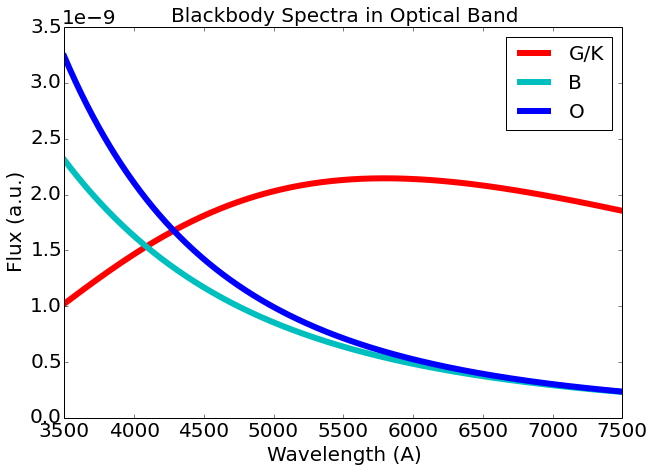

In [39]:
lam = np.linspace(3500,7500,5000) * u.Angstrom
T1 = 5000 * u.K
T2 = 18500 * u.K
T3 = 30000 * u.K

plt.figure(figsize=(10,7))
plt.plot(lam,blackbodymodel(lam, T1, 4e5),'r',label='G/K',lw=6)
plt.plot(lam,blackbodymodel(lam, T2, 2e3),'c',label='B',lw=6)
plt.plot(lam,blackbodymodel(lam, T3, 1e3),'b',label='O',lw=6)
plt.legend(loc='upper right')
plt.title('Blackbody Spectra in Optical Band'); plt.xlabel('Wavelength (A)'); plt.ylabel('Flux (a.u.)')

The three curves correspond to the three stars we have (remember that we've thrown away $\gamma$ UMa). Looks like it'll be hard to fit for the O and B stars. We will see

## <font color="red"> Capella</font>
Everybody clearly recalls that there was a severe condensation issue when we observed this star, which manifests itself as terrible fluctuations and strange features on top of the star's spectrum. But hopefully we'll still be able to fit a black-body spectrum to the more reliable part.

#### Fit

In [185]:
## mask out 'bad' spectrum where condensation might be dominating
#-- Be careful about units. wavelength must in A and T in K
mask = np.where(np.logical_and(capella_wvln>4500,capella_wvln<7000))
x = capella_wvln[mask]
y = capella_flux[mask]

popt, pcov = curve_fit(blackbodymodel_nounit, x, y, p0=(5000,1E5))

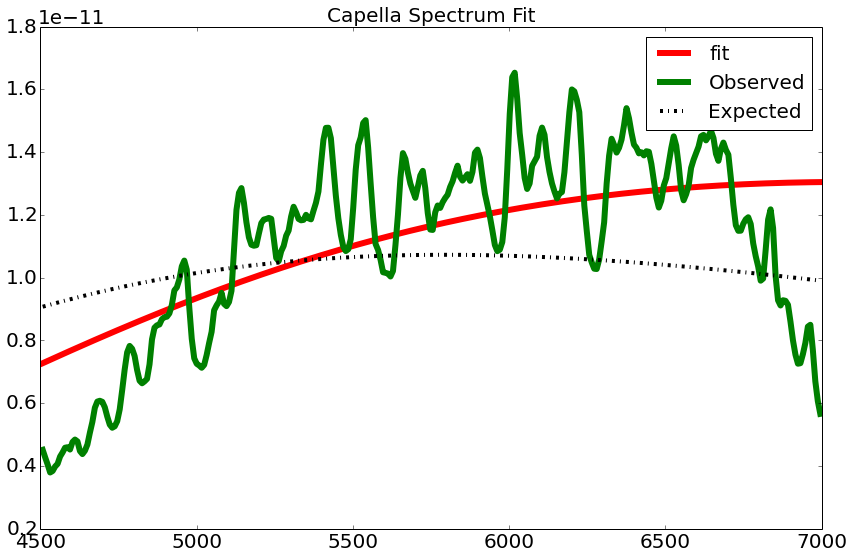

In [128]:
plt.figure(figsize=(14,9))
plt.plot(x, blackbodymodel_nounit(x, *popt), 'r-', label='fit',lw=6)
plt.plot(x,y,'g-',lw=6,label='Observed'); 
plt.plot(x,blackbodymodel_nounit(x, 5000, 2e3),'k-.',label='Expected',lw=4)
plt.title('Capella Spectrum Fit'); plt.legend()

Apparently our observed spectrum is way too bumpy and sharp. Let's abandon this and resort to the sketchier approach: Wien's law.

### Wien's law - Eye fit
The law reads 
$$
\frac{\lambda_\text{peak}}{A} \approx 3\times10^{7}\left(\frac{T}{K}\right)^{-1}
$$
For example, for $T=5000$K, we'll have $\lambda_\text{peak}\approx 6000$A

#### Peak of Capella's spectrum
OK, I think it's safe to say the peak is indeed around 6000A:

In [92]:
pk = x[np.where(y==np.max(y))][0]
print 'Peaking wavelength is {0:.1f}A'.format(pk)

Peaking wavelength is 6017.9A


Then the corresponding temperature:

In [93]:
tk = 3e7/pk
print 'Surface temperature is {0:.0f}K'.format(tk)

Surface temperature is 4985K


### <font color="blue">Classification</font>
According to the common classification by temperature (e.g. [wiki](https://en.wikipedia.org/wiki/Stellar_classification#Harvard_spectral_classification)), Capella is a K star (but remember that there are in fact four stars...)

## <font color="red">$\eta$ Hya</font>
Let's turn to the second hardest one, in whose spectrum we probably have resolved a small fraction of the peak. But, we should remove anything near the edge (3500A)

#### Fit

In [107]:
## mask out 'bad' spectrum where condensation might be dominating
#-- Be careful about units. wavelength must in A and T in K
mask = np.where(np.logical_and(eta_hya_wvln>3700,eta_hya_wvln<7000))
x1 = eta_hya_wvln[mask]
y1 = eta_hya_flux[mask]

popt1, pcov1 = curve_fit(blackbodymodel_nounit, x1, y1, p0=(18500,1E3))

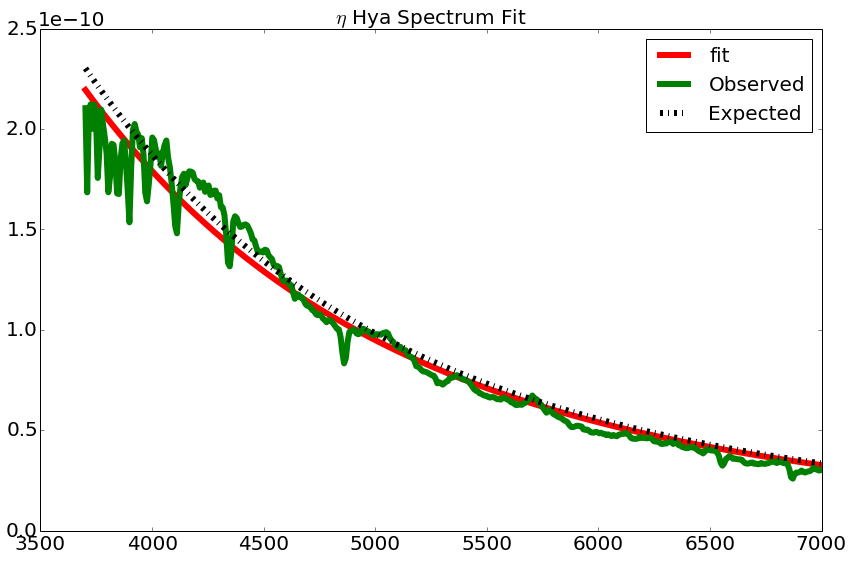

In [127]:
plt.figure(figsize=(14,9))
plt.plot(x1, blackbodymodel_nounit(x1, *popt1), 'r-', label='fit',lw=6)
plt.plot(x1,y1,'g-',lw=6,label='Observed'); 
plt.plot(x1,blackbodymodel_nounit(x1, 18500, 2.3e2),'k-.',label='Expected',lw=6)
plt.title('$\eta$ Hya Spectrum Fit'); plt.legend()

Pretty good. What's the best-fit temperature?

In [117]:
tk_eta = popt1[0]
print 'Best-fit temperature: {0:.0f}'.format(tk_eta)

Best-fit temperature: 17951


Very close to the "true" value 18500. 
### <font color="blue">Classification</font>
Again, referring to the Harvard classification system, we conclude that $\eta$ Hya is a B star. Of course, this is on e of our reference stars, so the correctness is well anticipated.

## <font color="red">$\alpha$ Cam</font>
Well, then, the final difficult task. By inspecting the spectrum, we already saw that the response near the low-frequency end was quite awful...

#### Fit
_Note: It turns out that everything below ~3800 is poorly recorded in my first trial of fitting. See the last section_

In [186]:
## mask out 'bad' spectrum where condensation might be dominating
#-- Be careful about units. wavelength must in A and T in K
mask = np.where(np.logical_and(alpha_cam_wvln>3800,alpha_cam_wvln<7400))
x2 = alpha_cam_wvln[mask]
y2 = alpha_cam_flux[mask]

popt2, pcov2 = curve_fit(blackbodymodel_nounit, x2, y2, p0=(30000,1E2))

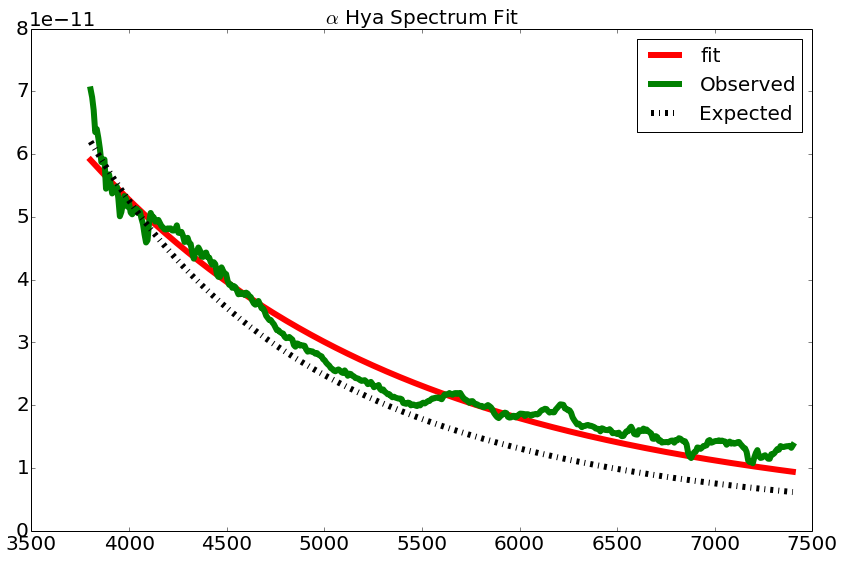

In [134]:
plt.figure(figsize=(14,9))
plt.plot(x2, blackbodymodel_nounit(x2, *popt2), 'r-', label='fit',lw=6)
plt.plot(x2,y2,'g-',lw=6,label='Observed'); 
plt.plot(x2,blackbodymodel_nounit(x2, 30000, 2.5e1),'k-.',label='Expected',lw=6)
plt.title(r'$\alpha$ Hya Spectrum Fit'); plt.legend()

Probably good for calculating the temperature:

In [135]:
tk_alpha = popt2[0]
print 'Best-fit temperature: {0:.0f}'.format(tk_alpha)

Best-fit temperature: 14565


Not satisfactory (true value is 30000). The largely "undetermined" shape at high-frequency range rendered the fitting futile: See how similar the two curves (red and dashed) are. How can the computer tell one from the other under this condition?

### Classification
There is no point in doing Wien's law either since the peak is far off: $\lambda_\text{peak}\approx 1000$A:

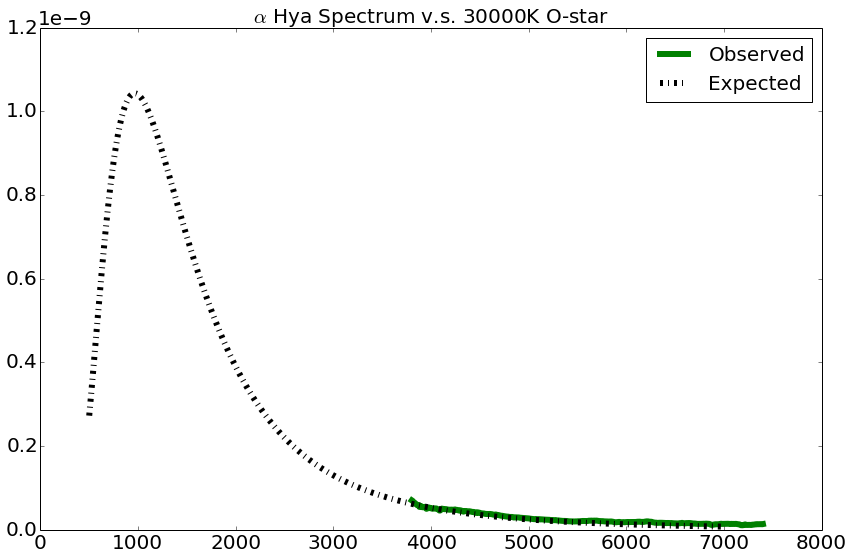

In [141]:
plt.figure(figsize=(14,9))
plt.plot(x2,y2,'g-',lw=6,label='Observed'); 
plt.plot(np.linspace(500,7000,5000),
         blackbodymodel_nounit(np.linspace(500,7000,5000), 30000, 2.5e1),
         'k-.',label='Expected',lw=6)
plt.title(r'$\alpha$ Hya Spectrum v.s. 30000K O-star'); plt.legend()

The only thing we can claim for sure is that the temperature of the star should be higher than 8285K, which will peak at 3500A, our cutoff wavelength.

---
## Johnson Filters
We downloaded the filters from the AIP Leibniz-Institut [website](http://www.aip.de/en/research/facilities/stella/instruments/data/johnson-ubvri-filter-curves), publicaly available.

In [143]:
B_filter = np.loadtxt("Bessel_B-1.txt", delimiter=" ", dtype="string")
V_filter = np.loadtxt("Bessel_V-1.txt", delimiter=" ", dtype="string")

Some massage is required to convert them into proper format:

In [168]:
B_filter_new=[]
for item in B_filter:
    B_filter_new.append([10*float(item.split("\t\t")[0]),float(item.split("\t\t")[1])])
B_filter_new=np.array(B_filter_new)
print B_filter_new.shape
V_filter_new=[]
for item in V_filter:
    V_filter_new.append([10*float(item.split("\t\t")[0]),float(item.split("\t\t")[1])])
V_filter_new=np.array(V_filter_new)
print V_filter_new.shape

(1801, 2)
(1801, 2)


### The Appearance

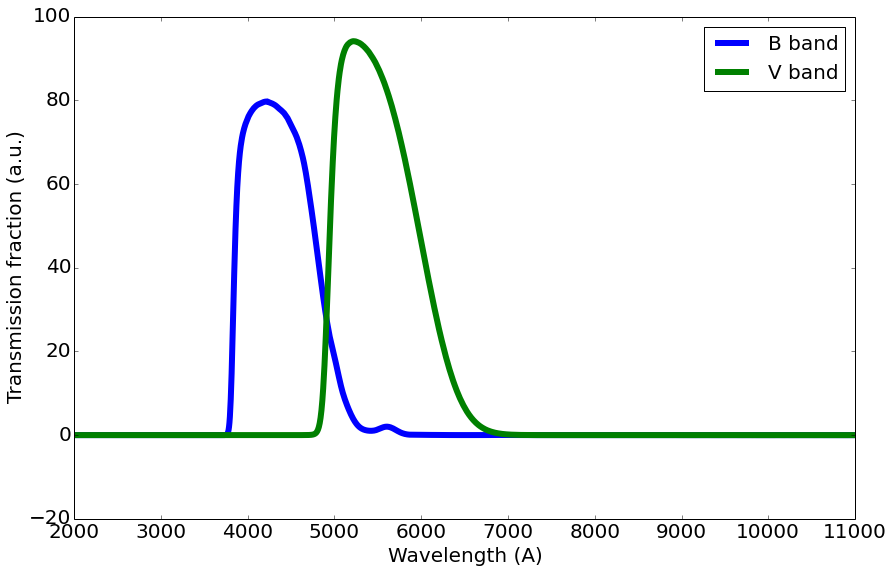

In [169]:
plt.figure(figsize=(14,9))
plt.plot(B_filter_new[:,0], B_filter_new[:,1], "b-", label="B band", lw=6)
plt.plot(V_filter_new[:,0], V_filter_new[:,1], "g-", label="V band", lw=6)
plt.legend()
plt.xlabel("Wavelength (A)")
plt.ylabel("Transmission fraction (a.u.)")

#### More massaging...
Before applying to our data, we also have to match the x-axis

In [173]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.integrate import trapz

## flipping
B_x = B_filter_new[:,0][::-1]
B_y = B_filter_new[:,1][::-1]

V_x = V_filter_new[:,0][::-1]
V_y = V_filter_new[:,1][::-1]

## interpolation
B_int = interp1d(B_x,B_y,kind='nearest')
V_int = interp1d(V_x,V_y,kind='nearest')

For each star...

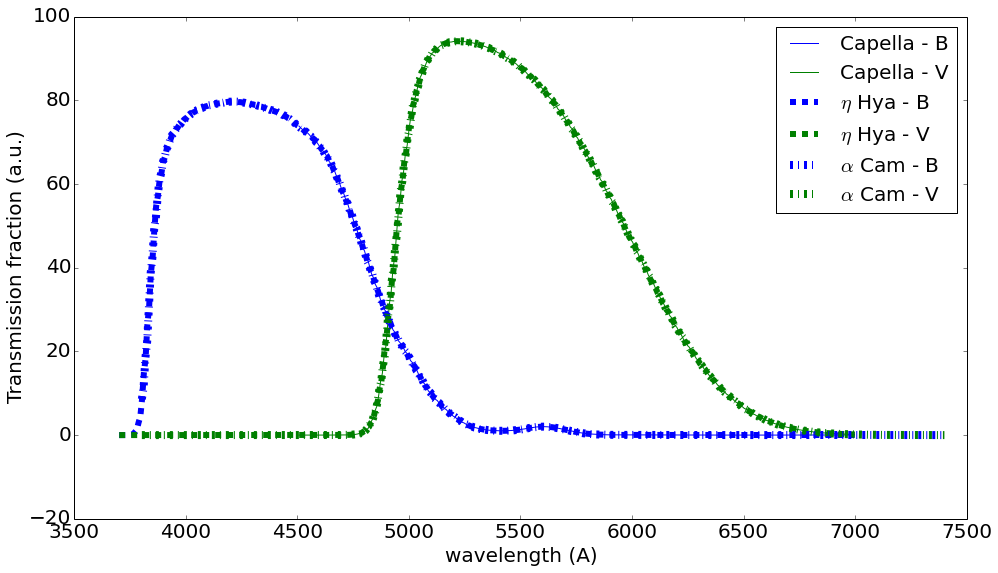

In [189]:
plt.figure(figsize=(16,9))

## capella
By_cap = B_int(x)
Vy_cap = V_int(x)
plt.plot(x, By_cap, "b", label="Capella - B")
plt.plot(x, Vy_cap, "g", label="Capella - V")

## eta_hya
By_eta = B_int(x1)
Vy_eta = V_int(x1)
plt.plot(x1, By_eta, "b--", label="$\eta$ Hya - B",lw=6)
plt.plot(x1, Vy_eta, "g--", label="$\eta$ Hya - V",lw=6)

## alpha_cam
By_alp = B_int(x2)
Vy_alp = V_int(x2)
plt.plot(x2, By_alp, "b-.", label=r"$\alpha$ Cam - B",lw=8)
plt.plot(x2, Vy_alp, "g-.", label=r"$\alpha$ Cam - V",lw=8)

plt.legend()
plt.xlabel("wavelength (A)")
plt.ylabel("Transmission fraction (a.u.)")

### Magnitudes
Translating fluxes into magnitudes makes use of some standard zero points. The numbers from the original [paper](http://adsabs.harvard.edu/abs/1998A%26A...333..231B) are used.

In [182]:
def VMag(x,y):
    Vy=V_int(x)
    total=trapz(Vy*y, x)/trapz(Vy, x)
    Vzero=trapz(Vy*363.1E-11, x)/trapz(Vy, x)
    return -2.5*np.log10(total/Vzero)
def BMag(x,y):
    By=B_int(x)
    total=trapz(By*y, x)/trapz(By, x)
    Bzero=trapz(By*632.1E-11, x)/trapz(By, x)
    return -2.5*np.log10(total/Bzero)

In [190]:
print "-"*20
print '  Capella:'
print "V mag    : {0:.2f}".format(VMag(x,y))
print "B-V color: {0:.2f}".format(BMag(x,y)-VMag(x,y))
print ''
print '-'*20
print '  Eta Hya:'
print "V mag    : {0:.2f}".format(VMag(x1,y1))
print "B-V color: {0:.2f}".format(BMag(x1,y1)-VMag(x1,y1))
print ''
print '-'*20
print "  Alpha Cam:"
print "V mag    : {0:.2f}".format(VMag(x2,y2))
print "B-V color: {0:.2f}".format(BMag(x2,y2)-VMag(x2,y2))

--------------------
  Capella:
V mag    : 6.21
B-V color: 1.28

--------------------
  Eta Hya:
V mag    : 4.28
B-V color: -0.21

--------------------
  Alpha Cam:
V mag    : 5.56
B-V color: -0.14


### Conclusions
In terms of magnitude
* B-V  : Capella > $\alpha$ Cam > $\eta$ Hya
* V mag: Capella > $\alpha$ Cam > $\eta$ Hya

These conform to our expectations as (1) Capella is a G/K star, so the total luminosity is (intrinsically) dimmer if everything else is the same. (2) B-V quantifies the trend towards O/B/A stars, we see that the O and B stars clearly show brighter B color. (3) Nevertheless, due to size, distance, etc. the B star turns out to be the brighter amongst all.

---
## <font color="grey"> Supplementary Stuff </font>
Something produced in the course of analysis.

### Failure of $\alpha$ Cam
As alluded to above, the spectral response below ~3800A was weirdly off, as can be seen in the comparison below for expected O-star spectrum and the observed spectrum. Yet everything above that "critical" wavelength seems just fine.

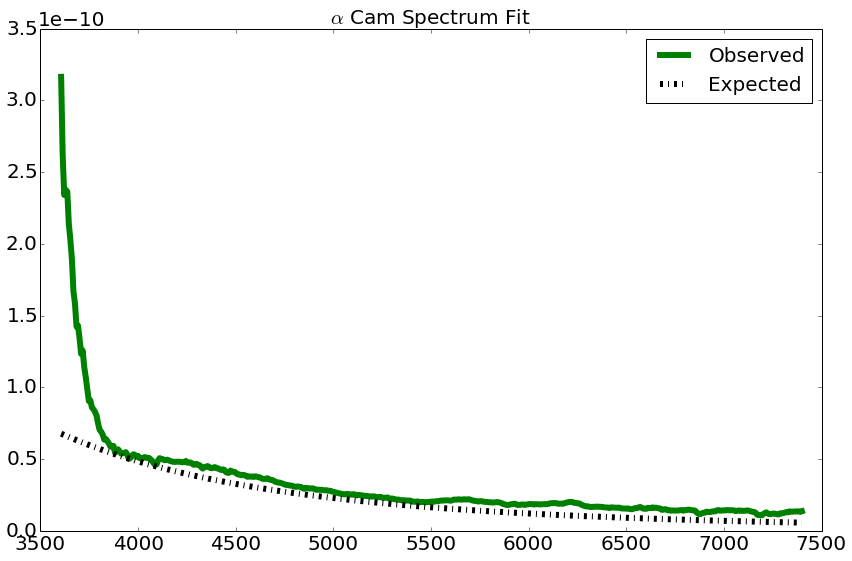

In [126]:
plt.figure(figsize=(14,9))
plt.plot(x2,y2,'g-',lw=6,label='Observed'); 
plt.plot(x2,blackbodymodel_nounit(x2, 30000, 2.3e1),'k-.',label='Expected',lw=6)
plt.title(r'$\alpha$ Cam Spectrum Fit'); plt.legend()